# __Predicting NTL using DTL__

## Setup

In [15]:
from numpy.random import seed

import os, datetime
import numpy as np
import pandas as pd
import json
import re 

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.utils import plot_model
import tensorflow.keras as K

import logging, os 
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# Set seeds. Note that using a GPU can still introduce randomness.
# (also not taking into account tensorflow randomness)
seed(42)

## Functions

In [91]:
def normalize(X):
    '''
    Normalizes features.
    '''
    return X.astype('float32') / 255.0

def define_model_imagenet(height, width, num_classes):
    '''
    Defines and compiles CNN model.
    
    Inputs:
        height, width, channels, num_classes (int)
    Returns:
        model (keras.Model object)
    '''

    # https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5
    # https://towardsdatascience.com/cnn-transfer-learning-fine-tuning-9f3e7c5806b2

    #### Base model
    input_shape = (height, width, 3)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape, pooling = "max")

    for layer in base_model.layers:
        layer.trainable = False

    #### Model Customization
    # We take the last layer of our the model and add it to our classifier
    last = base_model.layers[-1].output
    x = Flatten()(last)
    x = Dense(100, activation='relu', name='fc1')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    model = Model(base_model.input, x)
    # We compile the model
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    return model

def evaluate_model(model, trainX, trainY, testX, testY, CNN_MODEL_CHECKPOINT):
    '''
    Fits model, evaluates model, saves best model over epochs and cross-validations.
    
    Inputs:
        model (CNN model) keras.Model object
        trainX, trainY (numpy.ndarray) 4D array of DTL features and 2D array of targets for training
        testX, testY (numpy.ndarray) 4D array of DTL features and 2D array of targets for testing
        current_kfold (int) iteration in kfold cross-val, default=None for no cross-val
        display_metrics (bool) Default=False
    Returns:
        None
    # https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29
    '''

    # Use early stopping to help with overfitting
    es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=False)

    # Save best model based on accuracy
    mc = ModelCheckpoint(CNN_MODEL_CHECKPOINT, monitor='val_loss', mode='min', 
                         verbose=True, save_best_only=True)

    # Fit model
    history = model.fit(trainX, trainY, 
            epochs=50, 
            batch_size=32, 
            validation_data=(testX, testY), 
            callbacks=[es, mc], 
            verbose=False)

    # Show accuracy
    loss, accuracy = model.evaluate(testX, testY, verbose=False)
    print(f'                              Accuracy: {accuracy}')

    return history
        
def evaluate_with_crossval(model, dataX, dataY, k=2):
    '''
    Performs evaulation with K-fold cross validation.
    
    Inputs:
        model (keras.Model object)
        dataX, dataY (numpy.ndarray) 4D array of DTL features and 2D array of targets 
                                     for training
        k (int)
    Returns:
        None
    '''
    # Define k-fold cross-val
    kfold = KFold(k, shuffle=True, random_state=1)
    # Loop through folds
    count = 1
    for train_idx, test_idx in kfold.split(dataX):
        print(f'{datetime.datetime.now()}    --- Current K-fold: {count} ---')
        # Select subsets for training and testing
        trainX, trainY, testX, testY = dataX[train_idx], dataY[train_idx], \
                                       dataX[test_idx], dataY[test_idx]
        # Pass to evaluate_model function
        evaluate_model(model, trainX, trainY, testX, testY)
        count += 1

def display_eval_metrics(model, testX, testY, n_ntl_bins):
    '''
    Displays evaluation metrics for a given trained model.
    '''
    # Get predictions
    predY = model.predict(testX)
    predY = np.argmax(predY, axis = 1)
    testY_bins = np.argmax(testY, axis = 1)
    # Generate classification report
    classes = ['Radiance Level %01d' %i for i in range(1,n_ntl_bins+1)]
    print(classification_report(testY_bins, predY, target_names=classes))
    
def plot_model_accuracy_loss(model_fit):
    '''
    Plots the validated and training accuracy as well as loss function side by side.
    
    Inputs:
        model_fit (model fit object) output from evaluate_model
    Outputs: 
        None
    '''
    
    fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, sharey = False)
    ax1.plot(model_fit.history['accuracy'])
    ax1.plot(model_fit.history['val_accuracy'])
    ax1.set_title("CNN Model Accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend(['Train', 'Validation'], loc='upper left')

    ax2.plot(model_fit.history['loss'])
    ax2.plot(model_fit.history['val_loss'])
    ax2.set_title("CNN Model Loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
def plot_model_architecture(model_object, path_to_graphviz_app, landscape = "Vertical"):
    '''
    Plots CNN model architecture in a visual diagram

    Inputs:
        model_object (CNN model) keras.Model object that comes from the output of define_model_imagenet or define_model_singlechannel. 
        path_to_graphviz_app (string) Local Pathway to the bin folder of graphviz application (https://graphviz.org/download/)
        landscape (string) Pass in "Vertical" to display the CNN model architecture vertically or type any other string to dsiplay results horizontally
    Returns:
        plot object
    '''
    
    os.environ["PATH"] += os.pathsep + path_to_graphviz_app
    if landscape == "Vertical":
        plot = plot_model(model_object, show_shapes=True, show_layer_names=True)
    else:
        plot = plot_model(model_object, show_shapes=True, show_layer_names=True, rankdir='LR')
    return plot
    
def split_train_test(DTL, NTL):
    # SPLIT DATA INTO TRAINING AND TESTING
    trainX, testX, raw_trainY, raw_testY = train_test_split(DTL, NTL, test_size=0.2)
    
    # PREP TRAINING AND TESTING DATA
    trainY = to_categorical(raw_trainY)
    testY = to_categorical(raw_testY)
    
    # PREP PIXELS IN FEATURES
    trainX, testX = normalize(trainX), normalize(testX)
    return (trainX, testX, trainY, testY)

def make_predictions(testX, testY, CNN_MODEL_PATH):
    '''
    Loads best model, makes predictions on testY using testX, saves predicted values to s3.
    
    Inputs:
        testX
        testY 
    Outputs: 
        None
    '''
    ## Save dataframe of predicted versus actual values

    best_model = load_model(CNN_MODEL_PATH)
    
    # Predict Values
    predY = best_model.predict(testX) # model.predict(testX)
    predY = np.argmax(predY, axis = 1)
    testY_bins = np.argmax(testY, axis = 1)
    
    # Make Dataframe
    results_df = pd.DataFrame({'predY': predY, 'testY': testY_bins})
    
    CSV_PATH = CNN_MODEL_PATH.replace('.h5', '_predictions.csv')
    
    # Save locally
    results_df.to_csv(CSV_PATH, index=False) 

## Parameters

In [70]:
image_height = 48
image_width = 48

## Implement Models - VIIRS

In [71]:
# Define path to CNN files
import config as cf
CNN_FOLDER = os.path.join(cf.GD_CNN_DIRECTORY, 'VIIRS')

In [72]:
# Load VIIRS (dependent variable)
viirs = pd.read_pickle(os.path.join(CNN_FOLDER, 'dep_var.pkl'))

In [73]:
# List of DTL files
cnn_files = os.listdir(os.path.join(CNN_FOLDER))
reg = re.compile(r'^dtl.*npy$')                   
dtl_files = list(filter(reg.search, cnn_files)) 

(800, 48, 48, 3)
(200, 48, 48, 3)

Epoch 00001: val_loss improved from inf to 0.23712, saving model to /Users/robmarty/Google Drive/World Bank/IEs/Pakistan Poverty Estimation/Data/CNN/VIIRS/CNN_DEPVAR_median_rad_2014_5bin_DTLFIlE_dtl5_rgb_2014.h5

Epoch 00002: val_loss improved from 0.23712 to 0.21328, saving model to /Users/robmarty/Google Drive/World Bank/IEs/Pakistan Poverty Estimation/Data/CNN/VIIRS/CNN_DEPVAR_median_rad_2014_5bin_DTLFIlE_dtl5_rgb_2014.h5

Epoch 00003: val_loss improved from 0.21328 to 0.21203, saving model to /Users/robmarty/Google Drive/World Bank/IEs/Pakistan Poverty Estimation/Data/CNN/VIIRS/CNN_DEPVAR_median_rad_2014_5bin_DTLFIlE_dtl5_rgb_2014.h5

Epoch 00004: val_loss improved from 0.21203 to 0.20574, saving model to /Users/robmarty/Google Drive/World Bank/IEs/Pakistan Poverty Estimation/Data/CNN/VIIRS/CNN_DEPVAR_median_rad_2014_5bin_DTLFIlE_dtl5_rgb_2014.h5

Epoch 00005: val_loss did not improve from 0.20574

Epoch 00006: val_loss did not improve from 0.2057

/Users/robmarty/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

Radiance Level 1       0.93      1.00      0.96       185
Radiance Level 2       0.00      0.00      0.00        15

        accuracy                           0.93       200
       macro avg       0.46      0.50      0.48       200
    weighted avg       0.86      0.93      0.89       200



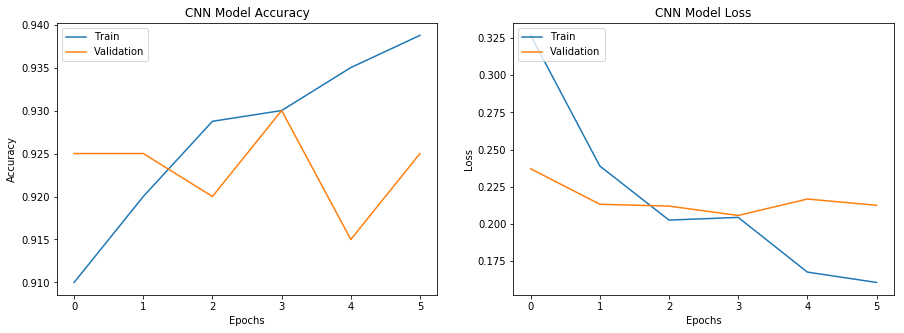

(800, 48, 48, 3)
(200, 48, 48, 3)

Epoch 00001: val_loss improved from inf to 0.24685, saving model to /Users/robmarty/Google Drive/World Bank/IEs/Pakistan Poverty Estimation/Data/CNN/VIIRS/CNN_DEPVAR_median_rad_2014_5bin_DTLFIlE_dtl4_3_2_rgb_2014.h5

Epoch 00002: val_loss did not improve from 0.24685

Epoch 00003: val_loss did not improve from 0.24685
                              Accuracy: 0.9100000262260437
                  precision    recall  f1-score   support

Radiance Level 1       0.91      0.99      0.95       181
Radiance Level 2       0.67      0.11      0.18        19

        accuracy                           0.91       200
       macro avg       0.79      0.55      0.57       200
    weighted avg       0.89      0.91      0.88       200



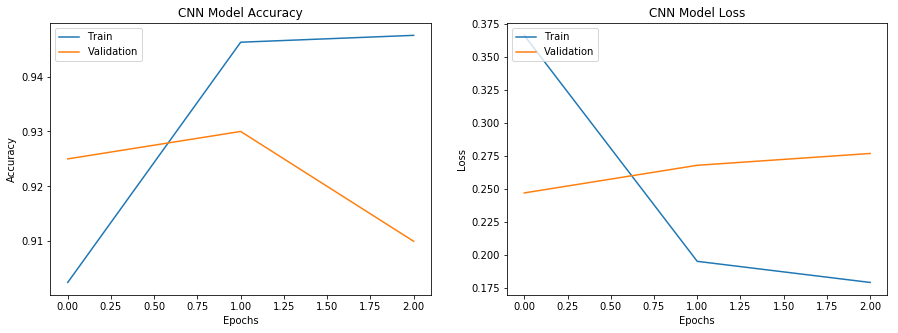

(800, 48, 48, 3)
(200, 48, 48, 3)

Epoch 00001: val_loss improved from inf to 0.22477, saving model to /Users/robmarty/Google Drive/World Bank/IEs/Pakistan Poverty Estimation/Data/CNN/VIIRS/CNN_DEPVAR_median_rad_2014_5bin_DTLFIlE_dtl6_rgb_2014.h5

Epoch 00002: val_loss improved from 0.22477 to 0.22432, saving model to /Users/robmarty/Google Drive/World Bank/IEs/Pakistan Poverty Estimation/Data/CNN/VIIRS/CNN_DEPVAR_median_rad_2014_5bin_DTLFIlE_dtl6_rgb_2014.h5

Epoch 00003: val_loss did not improve from 0.22432

Epoch 00004: val_loss did not improve from 0.22432
                              Accuracy: 0.9399999976158142
                  precision    recall  f1-score   support

Radiance Level 1       0.94      1.00      0.97       188
Radiance Level 2       0.00      0.00      0.00        12

        accuracy                           0.94       200
       macro avg       0.47      0.50      0.48       200
    weighted avg       0.88      0.94      0.91       200



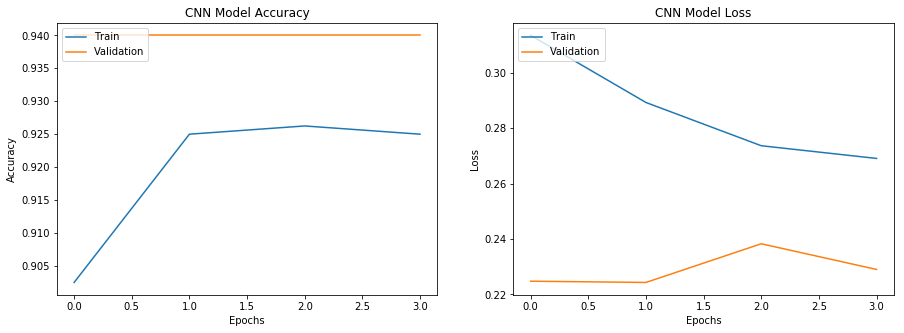

(800, 48, 48, 3)
(200, 48, 48, 3)

Epoch 00001: val_loss improved from inf to 0.22285, saving model to /Users/robmarty/Google Drive/World Bank/IEs/Pakistan Poverty Estimation/Data/CNN/VIIRS/CNN_DEPVAR_median_rad_2014_5bin_DTLFIlE_dtl7_rgb_2014.h5

Epoch 00002: val_loss did not improve from 0.22285

Epoch 00003: val_loss improved from 0.22285 to 0.21539, saving model to /Users/robmarty/Google Drive/World Bank/IEs/Pakistan Poverty Estimation/Data/CNN/VIIRS/CNN_DEPVAR_median_rad_2014_5bin_DTLFIlE_dtl7_rgb_2014.h5

Epoch 00004: val_loss did not improve from 0.21539

Epoch 00005: val_loss did not improve from 0.21539
                              Accuracy: 0.9300000071525574
                  precision    recall  f1-score   support

Radiance Level 1       0.93      1.00      0.96       184
Radiance Level 2       1.00      0.12      0.22        16

        accuracy                           0.93       200
       macro avg       0.96      0.56      0.59       200
    weighted avg       0.93  

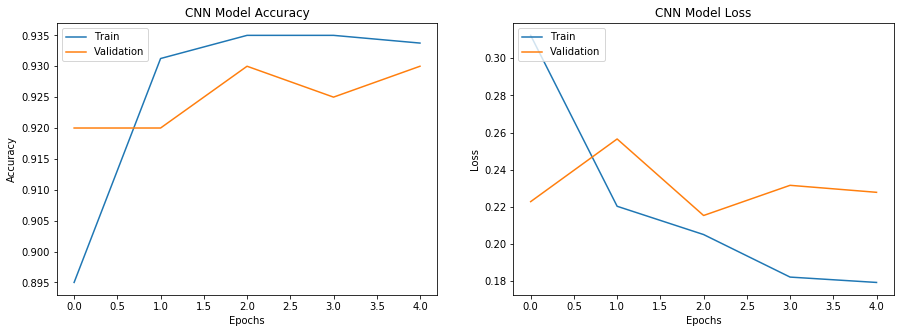

In [101]:
# Loop through files/parameters and estimate CNN model

# LOOP THROuGH DTL FILES (rgb, b5, etc.) 
for dtl_file_i in dtl_files:

    DTL = np.load(os.path.join(CNN_FOLDER, dtl_file_i))
    
    # If only one DTL band, repeat to make three
    if DTL.shape[3] == 1:
        DTL = np.repeat(DTL, 3, -1)

    # LOOP THROUGH DIFFERENT DEPENDENT VARIABLES    
    for dep_var in ['median_rad_2014_5bin']:

        # Define CNN Model Path/Name (.h5 file)
        dtl_file_i_clean = dtl_file_i.replace('.npy', '')
        CNN_MODEL_PATH = os.path.join(CNN_FOLDER, f'CNN_DEPVAR_{dep_var}_DTLFIlE_{dtl_file_i_clean}.h5')
        
        # Count number of unique dep var values. 
        # --Need this number for classification
        # --If a lot of unique numbers, do regression
        n_uniq_dep_vals = viirs[dep_var].value_counts().shape[0]  

        DEPVAR = viirs[dep_var].to_numpy()

        if n_uniq_ntl_vals <= 10:
            # Classification
            model = define_model_imagenet(image_height, image_width, n_uniq_dep_vals)
        else:
            dummy = 'dummy'
            # Regression
            # TODO: Define regression model

        # Split into train & test    
        trainX, testX, trainY, testY = split_train_test(DTL, DEPVAR)
        print(trainX.shape)
        print(testX.shape)

        # Evaluate Model
        history = evaluate_model(model, trainX, trainY, testX, testY, CNN_MODEL_PATH)

        # Evaluation Stats
        display_eval_metrics(model, testX, testY, n_uniq_dep_vals) #TODO: for classificaiton (not regression)
        plot_model_accuracy_loss(history)
        make_predictions(testX, testY, CNN_MODEL_PATH)